# Prepare data from Antonio 2019
Transform vcf with RCs into HDF5 that can be used by HAPSBURG

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp
from mpl_toolkits.basemap import Basemap

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Downsampe to 1240k SNPs and transform to HDF5
Needs to be run only one time!

In [20]:
def save_1240kmarkers(snp1240k_path, marker_path):
    """Save all 1240 Markers in csv - used for bcftools filtering"""
    df_snp = pd.read_csv(snp1240k_path, header=None, sep=r"\s+", engine="python")
    df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]
    print(f"Loaded {len(df_snp)} SNPs on all chromosomes.")
    df_save = df_snp[["chr", "pos"]]
    df_save.to_csv(marker_path, sep="\t", header=None, index=False)
    print(f"Saved {len(df_save)} 1240k Markers on all Chromosome to {marker_path}")

def bctools_filter_vcf_cluster(path_vcf, path_vcf_out, marker_path):
    """Filter to llist of variants with bcftools and directly via Marker Positions.
    path_vcf: Path of the input VCF
    path_vcf_out: Path where to save output VCF
    marer_path: Where to find the list of markers"""
    
    !module load bcftools; bcftools view -Oz -o $path_vcf_out -T $marker_path -m2 -M2 -v snps $path_vcf
    print(f"Finished BCF tools. Save filtered VCF to {path_vcf_out}")
    
def index_bcf_file(path_vcf):
    """Indexes a given vcf file"""
    !module load bcftools; bcftools index $path_vcf

In [23]:
marker_path = "./Data/1000Genomes/Markers/1240k/chrALL.csv" # Where to save list of downsampled SNPs to
snp1240k_path = "./Data/1000Genomes/Markers/MinMyc.snp"     # Where to find the 1240k SNPs

path_vcf = "./Data/Antonio/rmpr_unigeno.vcf.gz"
path_vcf_out = "./Data/Antonio/rmpr_unigeno_1240k.vcf.gz"   # Where to save the downsampled 1240k SNPs to
path_h5_out = "./Data/Antonio/rmpr_unigeno_1240k.hdf5"      # Where to save the final HDF4 to

In [15]:
%%time 
# Step 1: Prepare file with 1240k markers
save_1240kmarkers(snp1240k_path, marker_path)

Loaded 1233013 SNPs on all chromosomes.
Saved 1233013 1240k Markers on all Chromosome to ./Data/1000Genomes/Markers/1240k/chrALL.csv
CPU times: user 12.1 s, sys: 171 ms, total: 12.3 s
Wall time: 12.3 s


In [19]:
%%time
# Step 2: Downsample to VCF: Uncomment to run (takes 15 min!!)
bctools_filter_vcf_cluster(path_vcf=path_vcf, path_vcf_out=path_vcf_out, marker_path=marker_path)

Finished BCF tools. Save filtered VCF to ./Data/Antonio/rmpr_unigeno_1240k.vcf.gz
CPU times: user 20.8 s, sys: 2.78 s, total: 23.5 s
Wall time: 15min 10s


In [21]:
%%time
# Step 3: Create Index File for VCF
index_bcf_file(path_vcf_out)

CPU times: user 534 ms, sys: 80.2 ms, total: 614 ms
Wall time: 22.3 s


In [117]:
%%time
### Step 4: Transfer to HDF5
# Takes about 1min, alt_number makes only 1 alt allele
allel.vcf_to_hdf5(input=path_vcf_out, output=path_h5_out, compression="gzip", 
                  fields = ['CHROM', 'POS', 'AD', 'GT', "REF", "ALT", "ID", "samples"], alt_number=1)   

CPU times: user 1min 9s, sys: 520 ms, total: 1min 10s
Wall time: 1min 12s


# Prepare the Meta Data File
Prepares a Meta File in the standard format for this project

In [82]:
def process_antonio_meta(raw_path = "./Data/Antonio/meta_raw.csv", site_path = "./Data/Antonio/sites.csv",
                        save_path = "./Data/Antonio/meta_processed.csv", modify_iids=True, bp=True):
    """Process site level and ind level info into one Meta in Standard Format for HAPSBURG Analysis.
    modify_iids: Whether to modify IIDs to match samples"""
    df_raw = pd.read_csv(raw_path, sep="\t") # Load the data per each Individual
    df_site = pd.read_csv(site_path, sep="\t") # Load the data per site
    df_merge = pd.merge(df_raw, df_site, on="Site", how='left')
    print(f"Merged from {len(df_raw)} to {len(df_merge)} Individuals with spatial Information")

    ### Rename columns
    rename_dict = {'Date (Direct radiocarbon date on the individual calibrated 95% confidence interval or date range based on the archaeological context, including AMS dating of stratigraphic unit)':'age_range',
                  "Latitude":"lat", "Longitude":"lon", "Sample":"iid", "Period Label for Analyses":"clst", "Coverage":"mean_cov", "SNP Coverage":"n_cov_snp"}
    
    df_merge.rename(columns=rename_dict, inplace=True)
    df_merge["study"]="Antonio2019"
    df_merge["include_alt"]=1
    df_merge = post_process_age_antonio(df_merge, bp=bp)
    
    if modify_iids:
        df_merge["iid"] = df_merge["iid"].str.replace("R", "RMPR-")
        
        ### Add bs where needed
        iids_m = ["RMPR-474", "RMPR-475", "RMPR-435", "RMPR-437"]
        idx= df_merge["iid"].isin(iids_m)
        df_merge.loc[idx, "iid"] = df_merge.loc[idx,"iid"] + "b"  # Add the b

    df_full = df_merge[["iid", "lat", "lon", "age", "age_range", "study", "clst", "mean_cov", "n_cov_snp", "include_alt"]]
        
    if len(save_path)> 0:
        df_full.to_csv(save_path, index=None)  # sep='\t' would not work with downstream analysis
        print(f"Saved {len(df_full)} Individuals to {save_path}")

    return df_full

def post_process_age_antonio(df, bp=True):
    """Post Processes the age_range column of Antonio19 data.
    Return data frame with a age column.
    bp: If true: Report in Before Present time (1950), otherwise BCE"""
    age = df["age_range"].str.replace(" - ", "-")
    age = age.str.replace("- ", "-")  # one typo
    age = age.str.replace(" BCE-", "-")  # one typo
    age = age.str.split(r"\s+")

    ce_strings = ['CE', 'calCE']
    ce_idx = age.str[1].isin(ce_strings)  # where to flip the age

    num_age = age.str[0].str.split("-")
    mean_age = (num_age.str[0].astype("float") + num_age.str[1].astype("float"))/2.0
    mean_age[ce_idx] =  mean_age[ce_idx] * (-1) # Flip Age
    df["age"] = mean_age + bp*1950
    return df

In [83]:
df_full = process_antonio_meta(raw_path = "./Data/Antonio/meta_raw.csv", site_path = "./Data/Antonio/sites.csv",
                        save_path = "./Data/Antonio/meta_processed.csv")

Merged from 134 to 134 Individuals with spatial Information
Saved 134 Individuals to ./Data/Antonio/meta_processed.csv


# Area 51

In [118]:
### Test the Final HDF5 just created

f = h5py.File(path_h5_out, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 1037883 variants
Loaded 134 individuals
['AD', 'GT']
['ALT', 'CHROM', 'ID', 'POS', 'REF']


In [119]:
list(f)

['calldata', 'samples', 'variants']

In [120]:
list(f["calldata"])

['AD', 'GT']

In [123]:
f["samples"][:]

array(['RMPR-1014', 'RMPR-1015', 'RMPR-1016', 'RMPR-1021', 'RMPR-104',
       'RMPR-105', 'RMPR-106', 'RMPR-107', 'RMPR-108', 'RMPR-109',
       'RMPR-10', 'RMPR-110', 'RMPR-111', 'RMPR-113', 'RMPR-114',
       'RMPR-115', 'RMPR-116', 'RMPR-117', 'RMPR-118', 'RMPR-11',
       'RMPR-120', 'RMPR-1219', 'RMPR-121', 'RMPR-1220', 'RMPR-1221',
       'RMPR-1224', 'RMPR-122', 'RMPR-123', 'RMPR-125', 'RMPR-126',
       'RMPR-1283', 'RMPR-1285', 'RMPR-1286', 'RMPR-1287', 'RMPR-1288',
       'RMPR-1289', 'RMPR-128', 'RMPR-1290', 'RMPR-130', 'RMPR-131',
       'RMPR-132', 'RMPR-133', 'RMPR-134', 'RMPR-136', 'RMPR-137',
       'RMPR-1543', 'RMPR-1544', 'RMPR-1545', 'RMPR-1547', 'RMPR-1548',
       'RMPR-1549', 'RMPR-1550', 'RMPR-1551', 'RMPR-15', 'RMPR-16',
       'RMPR-17', 'RMPR-18', 'RMPR-19', 'RMPR-1', 'RMPR-22', 'RMPR-24',
       'RMPR-25', 'RMPR-26', 'RMPR-27', 'RMPR-28', 'RMPR-29', 'RMPR-2',
       'RMPR-30', 'RMPR-31', 'RMPR-32', 'RMPR-33', 'RMPR-34', 'RMPR-35',
       'RMPR-36', 'RMPR-37'

### Do Histogram of 1240k Coverage

In [69]:
### Calculate Coverage
np.shape(f["calldata/AD"])

(1037883, 134, 2)

In [111]:
f["calldata/AD"][20,:3,:]

array([[ 1,  0],
       [ 0,  1],
       [-1, -1]], dtype=int16)

In [79]:
cov = np.mean(f["calldata/AD"], axis=0)
cov = np.sum(cov, axis=1)

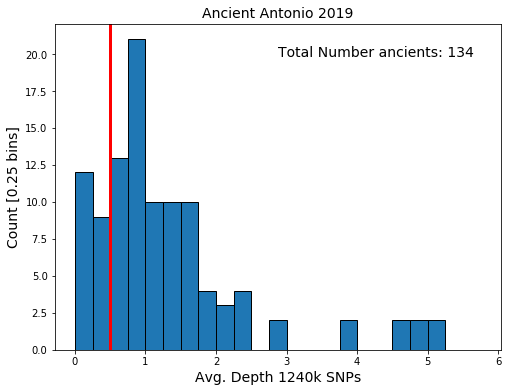

In [112]:
bins=np.arange(0, 6, 0.25)
fs = 14

plt.figure(figsize=(8,6))
ax = plt.gca()

plt.hist(cov, bins=bins, ec="k")
plt.xlabel("Avg. Depth 1240k SNPs", fontsize=fs)
plt.ylabel("Count [0.25 bins]", fontsize=fs)
ax.axvline(0.5, color="red", lw=3)
ax.text(x=0.5, y=0.9, 
        s=f"Total Number ancients: {len(cov)}", 
        transform=ax.transAxes, fontsize=fs)
plt.title("Ancient Antonio 2019", fontsize=fs)
plt.show()

## Check if Meta file processed correctly.
In particular, check whether it intersects fully with Samples in HDF5

In [79]:
df_t = pd.read_csv("./Data/Antonio/meta_processed.csv")

In [160]:
df_t[df_t["iid"] == "RMPR-1015"]

,iid,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
24,RMPR-1015,42.016838,12.100415,900 - 800 BCE,Antonio2019,Iron/Republic,0.87,290827,1


In [126]:
samples = f["samples"][:]

In [153]:
np.sum(df_t["iid"].isin(samples))  # Should be same as len() of samples

134

In [154]:
len(f["samples"])

134

### Verify the age post processing

In [84]:
df_t = pd.read_csv("./Data/Antonio/meta_processed.csv")

In [87]:
#df_t